In [87]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from cvx.covariance.ewma import iterated_ewma, _ewma_mean
from cvx.covariance.combination import from_sigmas
from cvx.covariance.regularization import regularize_covariance, em_regularize_covariance, from_cov_to_precisions, cvxpy_ccp_iteration, KL_div
from experiments.utils.experiment_utils import *
from experiments.utils.factor_model import *

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
returns = 100*pd.read_csv("../data/returns_large_universe.csv", index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [233]:
vola_half_life = 250
corr_half_life = 500

covariances = {}
for predictor in iterated_ewma(returns, vola_half_life, corr_half_life):
    covariances[predictor.time] = predictor.covariance

covariances_yearly = {}
covariances_yearly_non_causal = {}
years = returns.index.year.unique()[4:]

for year in years:
    # get mean of covariances on prior year
    covariances_yearly[year] = pd.DataFrame(np.mean([covariances[date] for date in covariances if date.year == year-1], axis=0), index=returns.columns, columns=returns.columns)
    
    covariances_yearly_non_causal[year] = pd.DataFrame(np.mean([covariances[date] for date in covariances if date.year == year], axis=0), index=returns.columns, columns=returns.columns)


In [234]:
covariance_no_reg = covariances_yearly
covariance_no_reg_non_causal = covariances_yearly_non_causal

In [6]:
def save_cov_to_csv(covs, name):
    """
    param covs: dictionary of time: covariance matrix
    name: name of the csv file

    Saves dataframe of upper triangular covariance matrices to csv file
    with indices being time stamps and columns being the upper triangular part
    """

    covs = {key: cov.values[np.triu_indices_from(cov.values, k=0)] for key, cov in covs.items()}
    covs = pd.DataFrame.from_dict(covs, orient='index')
    covs.index = pd.to_datetime(covs.index, format='%Y%m%d')
    covs.to_csv(f"results/{name}.csv")


def from_upper_triangular_to_full(cov):
    """
    param cov: upper triangular part of covariance matrix
    name: name of the csv file

    returns full covariance matrix
    """

    n = int(np.sqrt(2*len(cov)))
    
    # Reconstruct the full covariance matrix
    full_cov = np.zeros((n, n))
    rows, cols = np.triu_indices(n)
    full_cov[rows, cols] = cov
    full_cov[cols, rows] = cov

    return full_cov


def from_csv_to_cov(name, assets):
    """
    Reads csv file with upper triangular covariance matrices and, converts them
    to full covariance matrices and returns dictionary of time: covariance
    """
    covs = pd.read_csv(f"results/{name}.csv", index_col=0, parse_dates=True)
    covs = {key: pd.DataFrame(from_upper_triangular_to_full(cov), index=assets, columns=assets) for key, cov in covs.iterrows()}
    return covs 

In [109]:
# # covariance_no_reg is the covariance matrix each year 



# covariance_no_reg_non_causal_temp = returns.groupby(returns.index.year).apply(lambda x: x.cov())
# years = covariance_no_reg_non_causal_temp.index.get_level_values(0).unique()
# # make it a dictionary where the key is the year
# covariance_no_reg = {}
# for year in years[1:]:
#     covariance_no_reg[year] = covariance_no_reg_non_causal_temp.loc[year-1]

# covariance_no_reg_non_causal = {}
# for year in years:
#     covariance_no_reg_non_causal[year] = covariance_no_reg_non_causal_temp.loc[year]


### ADMM parameters

In [100]:
rho = 100
max_iter = 100
eps_abs = 1e-6
eps_rel = 1e-6
alpha = 1.8
max_iter_ccp = 5

### ADMM algorithm

##### $r=75$

In [ ]:
r = 75
Sigmas_low_rank75 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank75 = dict(from_cov_to_precisions(Sigmas_low_rank75))

In [ ]:
sample_ll75 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr75 = dict(regularize_covariance(covariance_no_reg, 75, low_rank_format=False))

svd_ll75 = log_likelihoods_from_sample_cov(svd_lr75, covariance_no_reg_non_causal)

In [146]:
ccp_lr75 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank75, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

100%|██████████| 22/22 [04:10<00:00, 11.37s/it]


In [147]:
ccp_sigmas75 = {}
for year in years[1:]:
    G = ccp_lr75[year].G
    e = ccp_lr75[year].e

    ccp_sigmas75[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll75 = log_likelihoods_from_sample_cov(ccp_sigmas75, covariance_no_reg_non_causal)

In [148]:
em_lr75 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank75))

em_sigmas75 = {}
for year in years[1:]:
    F = em_lr75[year].F
    d = em_lr75[year].d

    em_sigmas75[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll75 = log_likelihoods_from_sample_cov(em_sigmas75, covariance_no_reg_non_causal)

<Axes: >

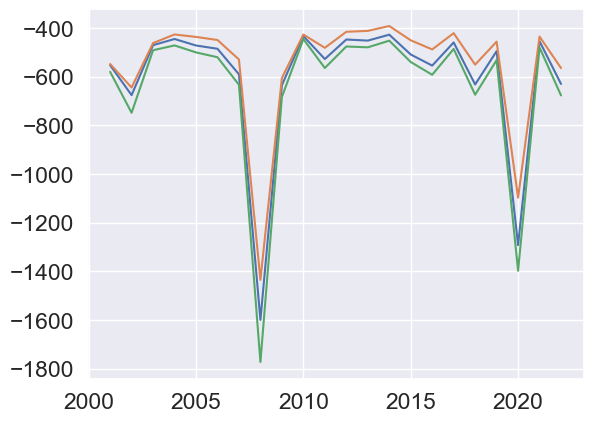

In [157]:
ccp_ll75.plot()
em_ll75.plot()
svd_ll75.plot()
# sample_ll75.plot()

In [162]:
print(ccp_ll75.mean())
print(em_ll75.mean())
print(svd_ll75.mean())

-601.8976244121405
-551.3152458872029
-645.4051869248357


##### $r=60$

In [152]:
r = 60
Sigmas_low_rank60 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank60 = dict(from_cov_to_precisions(Sigmas_low_rank60))

In [153]:
sample_ll60 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr60 = dict(regularize_covariance(covariance_no_reg, 60, low_rank_format=False))

svd_ll60 = log_likelihoods_from_sample_cov(svd_lr60, covariance_no_reg_non_causal)

In [154]:
ccp_lr60 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank60, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

100%|██████████| 22/22 [03:34<00:00,  9.74s/it]


In [155]:
ccp_sigmas60 = {}
for year in years[1:]:
    G = ccp_lr60[year].G
    e = ccp_lr60[year].e

    ccp_sigmas60[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll60 = log_likelihoods_from_sample_cov(ccp_sigmas60, covariance_no_reg_non_causal)

In [159]:
em_lr60 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank60))

em_sigmas60 = {}
for year in years[1:]:
    F = em_lr60[year].F
    d = em_lr60[year].d

    em_sigmas60[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll60 = log_likelihoods_from_sample_cov(em_sigmas60, covariance_no_reg_non_causal)

<Axes: >

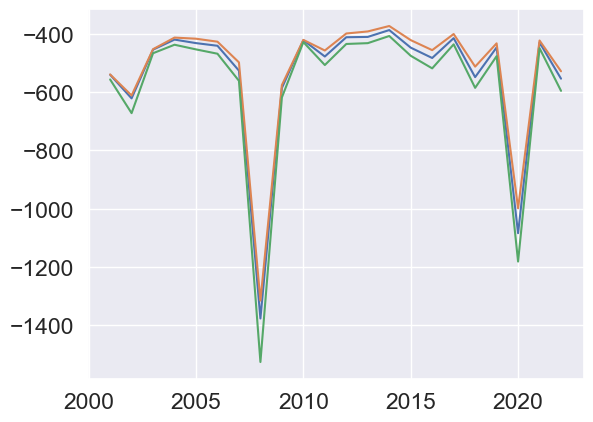

In [160]:
ccp_ll60.plot()
em_ll60.plot()
svd_ll60.plot()
# sample_ll60.plot()

In [163]:
print(ccp_ll60.mean())
print(em_ll60.mean())
print(svd_ll60.mean())

-541.2252518107694
-520.7636050312736
-576.3871846977586


##### $r=50$

In [164]:
r = 50
Sigmas_low_rank50 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank50 = dict(from_cov_to_precisions(Sigmas_low_rank50))

In [165]:
sample_ll50 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr50 = dict(regularize_covariance(covariance_no_reg, 50, low_rank_format=False))

svd_ll50 = log_likelihoods_from_sample_cov(svd_lr50, covariance_no_reg_non_causal)

In [166]:
ccp_lr50 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank50, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

100%|██████████| 22/22 [03:33<00:00,  9.72s/it]


In [167]:
ccp_sigmas50 = {}
for year in years[1:]:
    G = ccp_lr50[year].G
    e = ccp_lr50[year].e

    ccp_sigmas50[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll50 = log_likelihoods_from_sample_cov(ccp_sigmas50, covariance_no_reg_non_causal)

In [168]:
em_lr50 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank50))

em_sigmas50 = {}
for year in years[1:]:
    F = em_lr50[year].F
    d = em_lr50[year].d

    em_sigmas50[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll50 = log_likelihoods_from_sample_cov(em_sigmas50, covariance_no_reg_non_causal)

<Axes: >

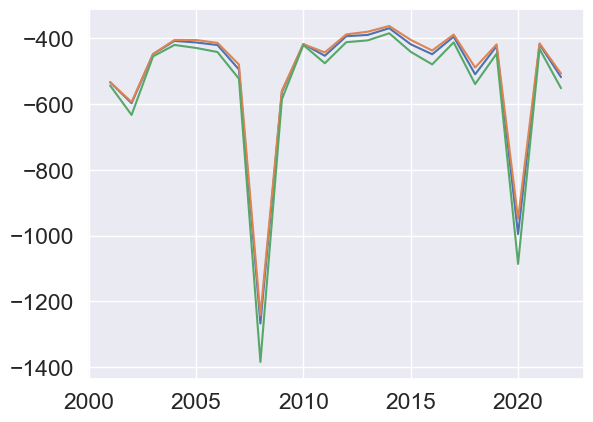

In [169]:
ccp_ll50.plot()
em_ll50.plot()
svd_ll50.plot()

In [170]:
print(ccp_ll50.mean())
print(em_ll50.mean())
print(svd_ll50.mean())

-513.8266048132665
-504.1180610199553
-541.4955872376021


##### $r=35$

In [171]:
r = 35
Sigmas_low_rank35 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank35 = dict(from_cov_to_precisions(Sigmas_low_rank35))

In [172]:
sample_ll35 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr35 = dict(regularize_covariance(covariance_no_reg, 35, low_rank_format=False))

svd_ll35 = log_likelihoods_from_sample_cov(svd_lr35, covariance_no_reg_non_causal)

In [173]:
ccp_lr35 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank35, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

100%|██████████| 22/22 [03:16<00:00,  8.95s/it]


In [174]:
ccp_sigmas35 = {}
for year in years[1:]:
    G = ccp_lr35[year].G
    e = ccp_lr35[year].e

    ccp_sigmas35[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll35 = log_likelihoods_from_sample_cov(ccp_sigmas35, covariance_no_reg_non_causal)

In [175]:
em_lr35 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank35))

em_sigmas35 = {}
for year in years[1:]:
    F = em_lr35[year].F
    d = em_lr35[year].d

    em_sigmas35[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll35 = log_likelihoods_from_sample_cov(em_sigmas35, covariance_no_reg_non_causal)

<Axes: >

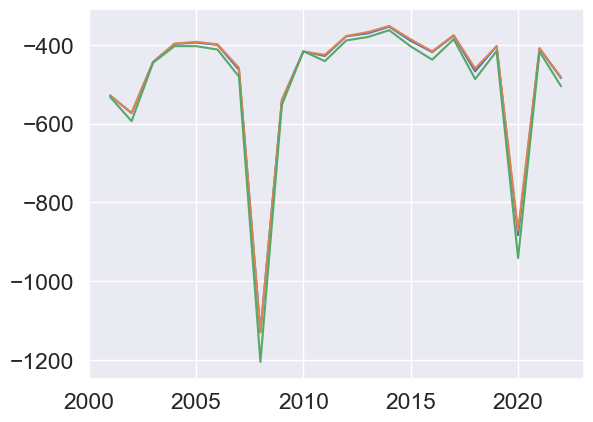

In [176]:
ccp_ll35.plot()
em_ll35.plot()
svd_ll35.plot()

In [177]:
print(ccp_ll35.mean())
print(em_ll35.mean())
print(svd_ll35.mean())

-484.20033475302404
-482.1388823469631
-500.6200813035128


##### $r=20$

In [178]:
r = 20
Sigmas_low_rank20 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank20 = dict(from_cov_to_precisions(Sigmas_low_rank20))

In [179]:
sample_ll20 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr20 = dict(regularize_covariance(covariance_no_reg, 20, low_rank_format=False))

svd_ll20 = log_likelihoods_from_sample_cov(svd_lr20, covariance_no_reg_non_causal)

In [180]:
ccp_lr20 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank20, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

100%|██████████| 22/22 [02:47<00:00,  7.60s/it]


In [181]:
ccp_sigmas20 = {}
for year in years[1:]:
    G = ccp_lr20[year].G
    e = ccp_lr20[year].e

    ccp_sigmas20[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll20 = log_likelihoods_from_sample_cov(ccp_sigmas20, covariance_no_reg_non_causal)

In [182]:
em_lr20 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank20))

em_sigmas20 = {}
for year in years[1:]:
    F = em_lr20[year].F
    d = em_lr20[year].d

    em_sigmas20[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll20 = log_likelihoods_from_sample_cov(em_sigmas20, covariance_no_reg_non_causal)

<Axes: >

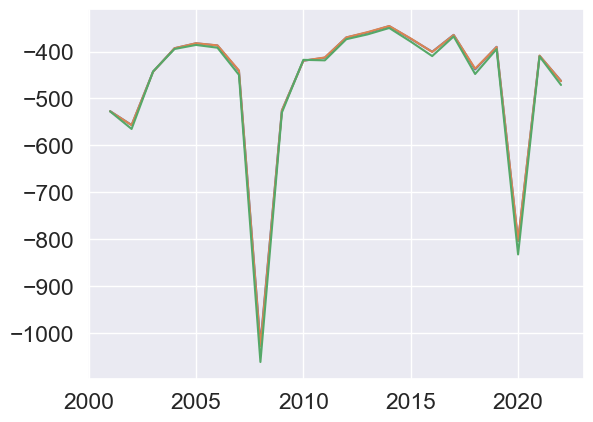

In [183]:
ccp_ll20.plot()
em_ll20.plot()
svd_ll20.plot()

In [184]:
print(ccp_ll20.mean())
print(em_ll20.mean())
print(svd_ll20.mean())

-465.0280803522823
-465.0437705129344
-472.1329959221342


##### $r=10$

In [185]:
r = 10
Sigmas_low_rank10 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank10 = dict(from_cov_to_precisions(Sigmas_low_rank10))

In [186]:
sample_ll10 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr10 = dict(regularize_covariance(covariance_no_reg, 10, low_rank_format=False))

svd_ll10 = log_likelihoods_from_sample_cov(svd_lr10, covariance_no_reg_non_causal)

In [187]:
ccp_lr10 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank10, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [02:23<00:00,  6.50s/it]


In [188]:
ccp_sigmas10 = {}
for year in years[1:]:
    G = ccp_lr10[year].G
    e = ccp_lr10[year].e

    ccp_sigmas10[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll10 = log_likelihoods_from_sample_cov(ccp_sigmas10, covariance_no_reg_non_causal)

In [189]:
em_lr10 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank10))

em_sigmas10 = {}
for year in years[1:]:
    F = em_lr10[year].F
    d = em_lr10[year].d

    em_sigmas10[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll10 = log_likelihoods_from_sample_cov(em_sigmas10, covariance_no_reg_non_causal)

<Axes: >

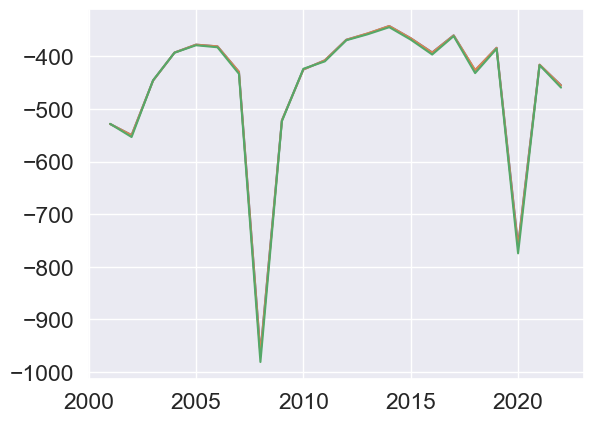

In [190]:
ccp_ll10.plot()
em_ll10.plot()
svd_ll10.plot()

In [191]:
print(ccp_ll10.mean())
print(em_ll10.mean())
print(svd_ll10.mean())

-456.7338946620988
-456.9203796435608
-459.82411353112343


##### $r=5$ 

In [192]:
r = 5
Sigmas_low_rank5 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank5 = dict(from_cov_to_precisions(Sigmas_low_rank5))

In [193]:
sample_ll5 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr5 = dict(regularize_covariance(covariance_no_reg, 5, low_rank_format=False))

svd_ll5 = log_likelihoods_from_sample_cov(svd_lr5, covariance_no_reg_non_causal)

In [194]:
ccp_lr5 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank5, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

100%|██████████| 22/22 [02:29<00:00,  6.78s/it]


In [195]:
ccp_sigmas5 = {}
for year in years[1:]:
    G = ccp_lr5[year].G
    e = ccp_lr5[year].e

    ccp_sigmas5[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll5 = log_likelihoods_from_sample_cov(ccp_sigmas5, covariance_no_reg_non_causal)

In [196]:
em_lr5 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank5))

em_sigmas5 = {}
for year in years[1:]:
    F = em_lr5[year].F
    d = em_lr5[year].d

    em_sigmas5[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll5 = log_likelihoods_from_sample_cov(em_sigmas5, covariance_no_reg_non_causal)

<Axes: >

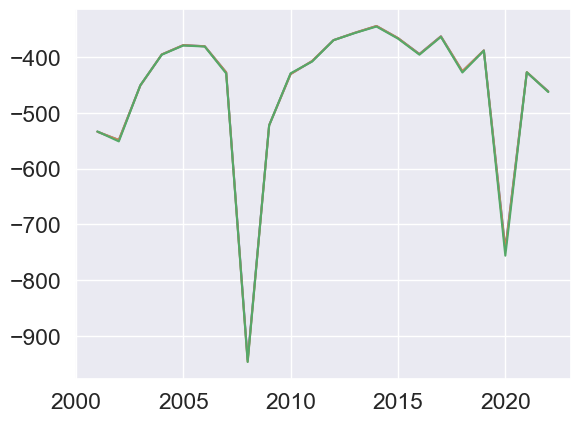

In [197]:
ccp_ll5.plot()
em_ll5.plot()
svd_ll5.plot()

In [198]:
print(ccp_ll5.mean())
print(em_ll5.mean())
print(svd_ll5.mean())

-457.04646291517497
-457.3090009576539
-458.4007950242495


##### $r=2$

In [199]:
r = 2
Sigmas_low_rank2 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank2 = dict(from_cov_to_precisions(Sigmas_low_rank2))

In [200]:
sample_ll2 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr2 = dict(regularize_covariance(covariance_no_reg, 2, low_rank_format=False))

svd_ll2 = log_likelihoods_from_sample_cov(svd_lr2, covariance_no_reg_non_causal)

In [201]:
ccp_lr2 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank2, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

100%|██████████| 22/22 [02:17<00:00,  6.24s/it]


In [202]:
ccp_sigmas2 = {}
for year in years[1:]:
    G = ccp_lr2[year].G
    e = ccp_lr2[year].e

    ccp_sigmas2[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll2 = log_likelihoods_from_sample_cov(ccp_sigmas2, covariance_no_reg_non_causal)

In [203]:
em_lr2 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank2))

em_sigmas2 = {}
for year in years[1:]:
    F = em_lr2[year].F
    d = em_lr2[year].d

    em_sigmas2[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll2 = log_likelihoods_from_sample_cov(em_sigmas2, covariance_no_reg_non_causal)

<Axes: >

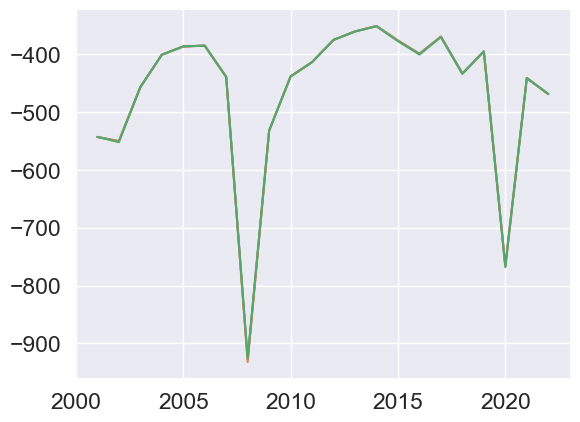

In [204]:
ccp_ll2.plot()
em_ll2.plot()
svd_ll2.plot()

In [205]:
print(ccp_ll2.mean())
print(em_ll2.mean())
print(svd_ll2.mean())

-464.2770735751021
-464.46026550806613
-464.5813587480562


In [207]:
ll_ccp_means = [ccp_ll2.mean(), ccp_ll5.mean(), ccp_ll10.mean(), ccp_ll20.mean(), ccp_ll35.mean(), ccp_ll50.mean(), ccp_ll60.mean(), ccp_ll75.mean()]
ll_em_means = [em_ll2.mean(), em_ll5.mean(), em_ll10.mean(), em_ll20.mean(), em_ll35.mean(), em_ll50.mean(), em_ll60.mean(), em_ll75.mean()]
ll_svd_means = [svd_ll2.mean(), svd_ll5.mean(), svd_ll10.mean(), svd_ll20.mean(), svd_ll35.mean(), svd_ll50.mean(), svd_ll60.mean(), svd_ll75.mean()]

rs = [2, 5, 10, 20, 35, 50, 60, 75]

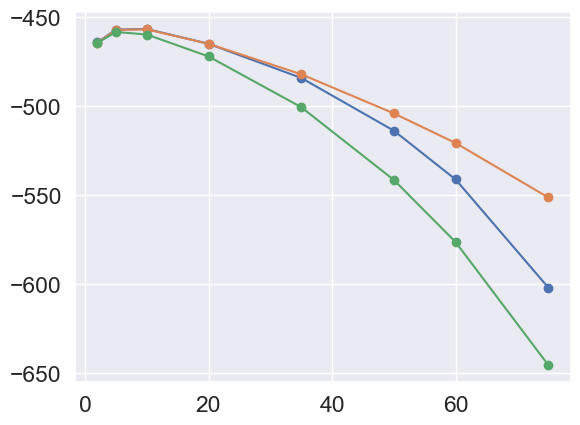

In [209]:
plt.plot(rs, ll_ccp_means, label="CCP", marker='o')
plt.plot(rs, ll_em_means, label="EM", marker='o')
plt.plot(rs, ll_svd_means, label="SVD", marker='o')